<a target="_blank" href="https://colab.research.google.com/github/SrjPdl/intel_image_classification_densenet">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Intel Image Classification with DenseNet Implementation in pytorch
The dataset is taken from kaggle [Intel Image Classification Dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification). It contains the images of Natural Scenes around the world.

The Data contains around 25k images of size 150x150 distributed under 6 categories.
``` python
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }
```
The Train, Test and Prediction data is separated in each folders. There are around 14k images in Train, 3k in Test and 7k in Prediction.

# Download the dataset and unzip

In [1]:
!gdown 1WwV3dsjxIAFlQNQ6TdgJL4mMJfRmaM9s

Downloading...
From: https://drive.google.com/uc?id=1WwV3dsjxIAFlQNQ6TdgJL4mMJfRmaM9s
To: /content/intel_image_classification.zip
100% 363M/363M [00:05<00:00, 68.5MB/s]


In [2]:
!unzip /content/intel_image_classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

# Imports

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import io
import requests
from PIL import Image
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define Directories

In [4]:
TRAIN_DATA_DIR = "/content/seg_train/seg_train"
TEST_DATA_DIR = "/content/seg_test/seg_test"
PRED_DATA_DIR = "/content/seg_pred/seg_pred"

# Some of the examples

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = ImageFolder(root=TRAIN_DATA_DIR, transform=transform)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=2)

In [6]:
labels_str_list = dataset.classes

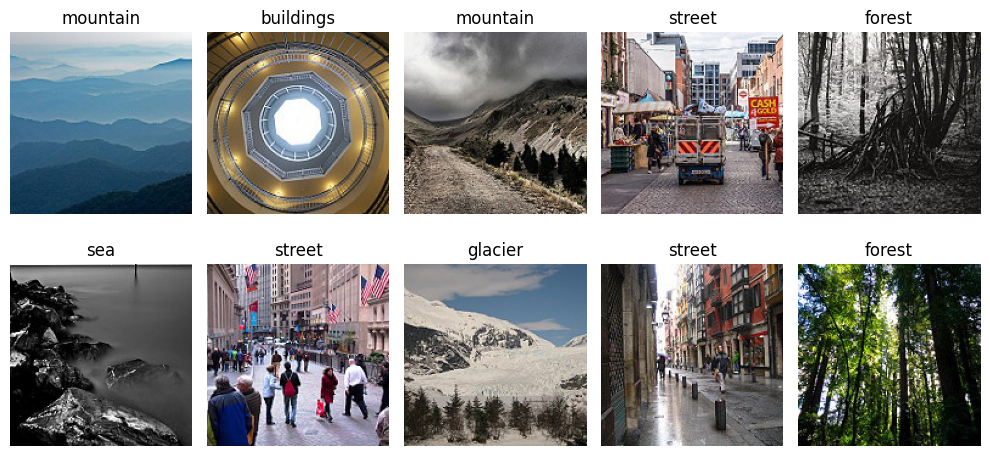

In [8]:
images, labels = next(iter(dataloader))
plt.figure(figsize=(10,5))
i = 1
for image,label in zip(images,labels):
  plt.subplot(2,5,i)
  plt.imshow(image.permute(1, 2, 0).numpy())
  plt.title(labels_str_list[int(label)])
  plt.axis("off")
  i += 1
plt.tight_layout()
plt.show()

# Distribution of classes
From the plot below we can see the classes are almost identically distributed in training set

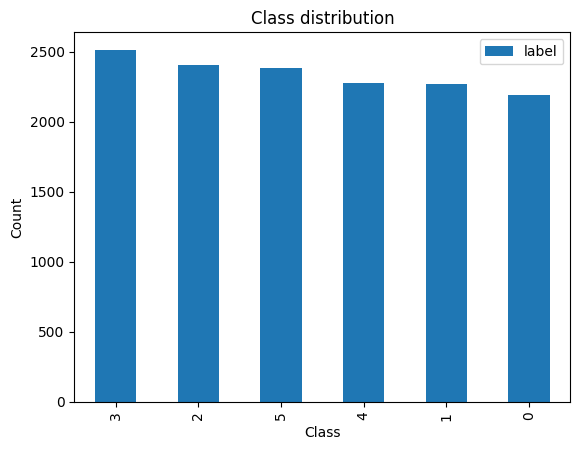

In [9]:
class_count_df = pd.DataFrame(dataset.imgs, columns=['path', 'label'])['label'].value_counts().to_frame()
class_count_df.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class distribution')
plt.show()

# Create pytorch dataloader for Train, Validation and Test set

In [10]:
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

full_train_dataset = ImageFolder(root=TRAIN_DATA_DIR, transform=transform)
train_dataset, val_dataset = train_test_split(full_train_dataset, test_size=0.2, random_state=10)
test_dataset = ImageFolder(root=TEST_DATA_DIR, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Building DenseNet for image classification
In DenseNet, each layer obtains additional inputs from all preceding layers and passes on its own feature-maps to all subsequent layers. Concatenation is used. Each layer is receiving a “collective knowledge” from all preceding layers.

# Transition Layer
Transition layers connect teo Dense Blocks. They are used in the DenseNet architecture which consists of a batch-norm layer, 1x1 convolution followed by a 2x2 average pooling layer between two contiguous dense blocks. It facilitates down-sampling in the architecture.
![dense_net](https://miro.medium.com/v2/resize:fit:720/format:webp/1*BJM5Ht9D5HcP5CFpu8bn7g.png)

In [11]:
class Transition(nn.Module):
  def __init__(self, num_in_channels, num_out_channels):
    super(Transition, self).__init__()
    self.bn = nn.BatchNorm2d(num_in_channels)
    self.conv = nn.Conv2d(num_in_channels, num_out_channels, kernel_size = 1, bias=False)

  def forward(self, x):
    output = self.conv(F.relu(self.bn(x)))
    output = F.avg_pool2d(output,2)
    return output

# Dense Layer
Each Dese block consists of multiple dense layers. For each dense layer, apply Batch Norm (BN) and ReLU, then 3x3 Conv are done with output feature maps of k channels.

In [12]:
class DenseLayer(nn.Module):
  def __init__(self, num_in_features, growth_rate):
    super(DenseLayer, self).__init__()
    self.bn = nn.BatchNorm2d(num_in_features)
    self.conv = nn.Conv2d(num_in_features, growth_rate, kernel_size = 3, padding = 1, bias = False)

  def forward(self, x):
    output = self.conv(F.relu(self.bn(x)))
    output = torch.cat((x, output), 1)
    return output

# Bottleneck Layer
 To reduce the model complexity and size Bottleneck layer can be used. BN-ReLU-1x1 Conv is done before BN-ReLU-3x3 Conv.
![bottle_neck](https://miro.medium.com/v2/resize:fit:720/format:webp/1*dniz8zK2ClBY96ol7YGnJw.png)

In [13]:
class BottleNeck(nn.Module):
  def __init__(self, num_in_channels, growth_rate):
    super(BottleNeck, self).__init__()
    num_intermediate_channels = 4 * growth_rate
    self.bn1 = nn.BatchNorm2d(num_in_channels)
    self.conv1 = nn.Conv2d(num_in_channels, num_intermediate_channels, kernel_size = 1, bias = False)
    self.bn2 = nn.BatchNorm2d(num_intermediate_channels)
    self.conv2 = nn.Conv2d(num_intermediate_channels,growth_rate, kernel_size = 3, bias = False, padding = 1)

  def forward(self, x):
    output = self.conv1(F.relu(self.bn1(x)))
    output = self.conv2(F.relu(self.bn2(output)))
    output = torch.cat((x,output), 1)
    return output

# DenseNet

In [14]:
class DenseNet(nn.Module):
  def __init__(self, num_in_channels, growth_rate, depth, reduction, num_classes, bottleneck = False):
        super(DenseNet, self).__init__()

        num_dense_blocks = (depth-4) // 3
        if bottleneck:
            num_dense_blocks //= 2

        num_channels = 2*growth_rate
        self.conv1 = nn.Conv2d(num_in_channels, num_channels, kernel_size=3, padding=1,
                               bias=False)
        self.dense1 = self._make_dense(num_channels, growth_rate, num_dense_blocks, bottleneck)
        num_channels += num_dense_blocks*growth_rate
        num_out_channels = int(np.floor(num_channels*reduction))
        self.trans1 = Transition(num_channels, num_out_channels)

        num_channels = num_out_channels
        self.dense2 = self._make_dense(num_channels, growth_rate, num_dense_blocks, bottleneck)
        num_channels += num_dense_blocks*growth_rate
        num_out_channels = int(np.floor(num_channels*reduction))
        self.trans2 = Transition(num_channels, num_out_channels)

        num_channels = num_out_channels
        self.dense3 = self._make_dense(num_channels, growth_rate, num_dense_blocks, bottleneck)
        num_channels += num_dense_blocks*growth_rate

        self.bn1 = nn.BatchNorm2d(num_channels)
        self.fc = nn.Linear(num_channels*81, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
  def _make_dense(self, num_channels, growthRate, nDenseBlocks, bottleneck):
        layers = []
        for i in range(int(nDenseBlocks)):
            if bottleneck:
                layers.append(BottleNeck(num_channels, growthRate))
            else:
                layers.append(DenseLayer(num_channels, growthRate))
            num_channels += growthRate
        return nn.Sequential(*layers)

  def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.dense3(out)
        out = F.avg_pool2d(F.relu(self.bn1(out)), 4)
        out= out.view(out.size(0), -1)
        out = F.log_softmax(self.fc(out), dim=1)
        return out

# Model Parameters

In [15]:
NUM_CHANNELS = 3
GROWTH_RATE = 12
DEPTH = 40
NUM_CLASSES = 6
REDUCTION = 0.1
BOTTLE_NECK = True

In [16]:
model = DenseNet(NUM_CHANNELS, GROWTH_RATE, DEPTH, REDUCTION, NUM_CLASSES, BOTTLE_NECK)

In [17]:
model

DenseNet(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): BottleNeck(
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BottleNeck(
      (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): BottleNeck(
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
model = model.to(device)

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch 1, Batch 1/351 - Loss: 1.9267, Accuracy: 0.0938
Epoch 1, Batch 101/351 - Loss: 0.8664, Accuracy: 0.6250
Epoch 1, Batch 201/351 - Loss: 0.5297, Accuracy: 0.8438
Epoch 1, Batch 301/351 - Loss: 0.8833, Accuracy: 0.6875

Epoch 1 - Average Train Loss: 0.9271, Accuracy: 0.6566
Epoch 1 - Validation Loss: 0.6314, Accuracy: 0.7642

Saved model as best_model.pt

Epoch 2, Batch 1/351 - Loss: 0.5543, Accuracy: 0.8125
Epoch 2, Batch 101/351 - Loss: 0.5756, Accuracy: 0.8125
Epoch 2, Batch 201/351 - Loss: 0.6787, Accuracy: 0.7500
Epoch 2, Batch 301/351 - Loss: 0.3334, Accuracy: 0.8750

Epoch 2 - Average Train Loss: 0.6261, Accuracy: 0.7771
Epoch 2 - Validation Loss: 0.7807, Accuracy: 0.7460

Epoch 3, Batch 1/351 - Loss: 0.4345, Accuracy: 0.8750
Epoch 3, Batch 101/351 - Loss: 0.6753, Accuracy: 0.8750
Epoch 3, Batch 201/351 - Loss: 0.6417, Accuracy: 0.8750
Epoch 3, Batch 301/351 - Loss: 0.5278, Accuracy: 0.8125

Epoch 3 - Average Train Loss: 0.5383, Accuracy: 0.8051
Epoch 3 - Validation Loss: 0.5

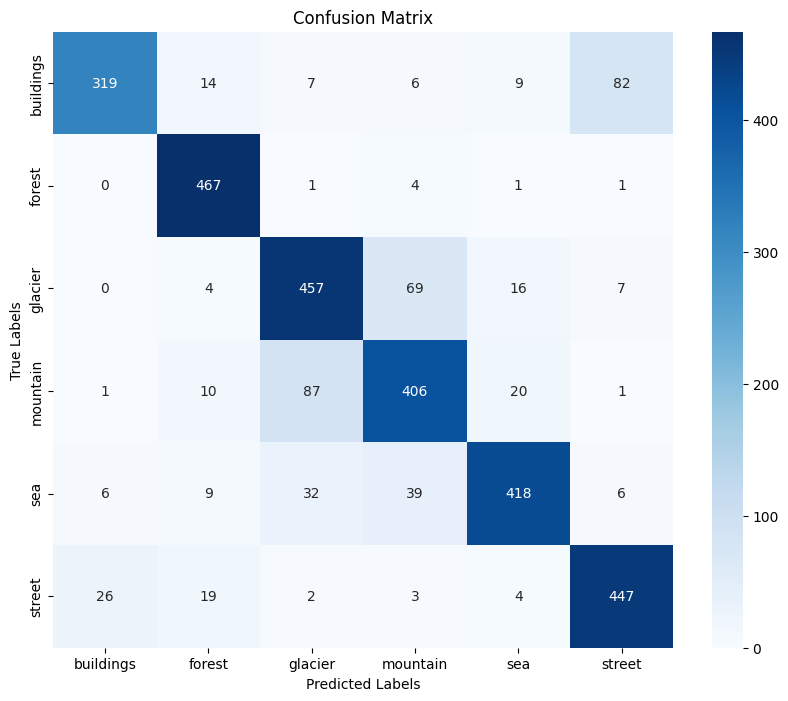

In [23]:
NUM_EPOCHS = 10
PRINT_FREQUENCY = 100
best_val_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    model.train()
    for batch_idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if batch_idx % PRINT_FREQUENCY == 0:
            batch_accuracy = (predicted == labels).sum().item() / labels.size(0)
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_dataloader)} - Loss: {loss.item():.4f}, Accuracy: {batch_accuracy:.4f}")

        del inputs
        del labels
        if device.type == "cuda":
            torch.cuda.empty_cache()

    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct / total

    print(f"\nEpoch {epoch+1} - Average Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            val_outputs = model(inputs)
            val_loss += loss_fn(val_outputs, labels).item()

            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (val_predicted == labels).sum().item()
            del inputs
            del labels
            if device.type == "cuda":
                torch.cuda.empty_cache()

    val_loss /= len(val_dataloader)
    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1} - Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}\n")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        print("Saved model as best_model.pt\n")

# After completing training, evaluate on test set
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        test_outputs = model(inputs)
        test_loss += loss_fn(test_outputs, labels).item()

        _, test_predicted = torch.max(test_outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (test_predicted == labels).sum().item()

        # Store predictions and true labels
        predictions.extend(test_predicted.tolist())
        true_labels.extend(labels.tolist())

        del inputs
        del labels
        if device.type == "cuda":
            torch.cuda.empty_cache()

test_loss /= len(test_dataloader)
test_accuracy = test_correct / test_total

print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=labels_str_list, yticklabels=labels_str_list)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Model Inference

In [24]:
model.load_state_dict(torch.load("/content/best_model.pt"))

<All keys matched successfully>

In [25]:
def handle_image_upload(data):

    img = Image.open(io.BytesIO(data))
    img = img.convert('RGB')

    preprocess = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    img = preprocess(img)

    img = img.unsqueeze(0).to(device)
    output = model(img)
    _, predicted = torch.max(output.data, 1)

    class_label = labels_str_list[predicted.item()]
    img = img.squeeze().permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Prediction: {class_label}')
    plt.show()


Saving ocean-water-beach-The-Bahamas-Grand-Bahama.webp to ocean-water-beach-The-Bahamas-Grand-Bahama.webp
User uploaded file "ocean-water-beach-The-Bahamas-Grand-Bahama.webp" with length 202714 bytes


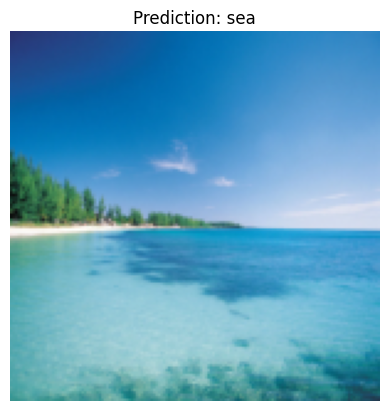

In [29]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  handle_image_upload(uploaded[fn])